In [ ]:
pwd

In [1]:
import os
os.chdir('f:\\iNeuron\\Projects\\scania_failures_2')
import pandas as pd
import numpy as np
from pprint import pprint
from pathlib import Path

import re
import mlflow
import mlflow.data
from mlflow.client import MlflowClient
import mlflow.pyfunc
client = MlflowClient(tracking_uri = 'https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow',
                      registry_uri = 'https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow')


from src.utils import (load_yaml,save_yaml,save_binary, params_extractor, params_evaluator,
                       eval_metrics, parameter_tuning, best_model_finder, 
                       stacking_clf_trainer, voting_clf_trainer, model_trainer, mlflow_logger)
from src.constants import *
from src.utils import load_yaml
from src.components.stage_3_data_split import data_splitting_component
from src.components.stage_4_final_preprocessing import stage_4_final_processing_component
from src.config.configuration_manager import ConfigurationManager
from src.entity.entity_config import (Stage2ProcessingConf,
                                      ModelMetricsConf, 
                                      ModelTrainerConf, 
                                      PreprocessorConf, 
                                      DataSplitConf,
                                      Stage1ProcessingConf)
from src import logger

import optuna

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, 
                              HistGradientBoostingClassifier, StackingClassifier, VotingClassifier)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.utils import eval_metrics
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

models = {'Logistic_Regression': LogisticRegression, 
            'SGD_Classifier': SGDClassifier,
            'Random Forest': RandomForestClassifier ,
            'Ada_Boost': AdaBoostClassifier, 
            'Grad_Boost': GradientBoostingClassifier, 
            'Bagging_Classifier': BaggingClassifier, 
            'ExtraTreesClassifier': ExtraTreesClassifier, 
            'Hist_Grad_Boost_Classifier': HistGradientBoostingClassifier, 
            'Decision_Tree_Classifier': DecisionTreeClassifier,
            'XGB_Classifier': XGBClassifier,
            'KNN_Classifier': KNeighborsClassifier,
            'Light_GBM' : LGBMClassifier,
            # 'Stacked_Classifier' : StackingClassifier,
            # 'Voting_Classifier' : VotingClassifier
            }


# import pandas as pd
# data_path = Path('F:\iNeuron\Projects\scania_failures_2\\artifacts\data\processed\stage_1_processing\preprocessed_train_data.csv')
# data = pd.read_csv(data_path)


os.environ['MLFLOW_TRACKING_URI']='https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow'
os.environ['MLFLOW_TRACKING_USERNAME']='Raj-Narayanan-B'
os.environ['MLFLOW_TRACKING_PASSWORD']='8af4cc66be8aec751397fd525e47ae395fa67442'

print(mlflow.get_tracking_uri())
print(mlflow.get_registry_uri())

# batch_size = 5000
# num_batches = data.shape[0] // batch_size
# data_shuffled = shuffle(data, random_state=42)

# batch_list = []
# # Iterate through batches
# for i in range(num_batches):
#     # Extract a batch
#     start_idx = i * batch_size
#     end_idx = ((i + 1) * batch_size)
#     # print(f"start_idx: {start_idx}, end_idx: {end_idx}")
#     batch_list.append(data_shuffled.iloc[start_idx:end_idx, :])

# sum1 = 0
# sum0 = 0
# for i in range(len(batch_list)):
#     print(f"Batch: {i}")
#     sum0 += batch_list[i]['class'].value_counts()[0] 
#     sum1 += batch_list[i]['class'].value_counts()[1] 
#     print(batch_list[i]['class'].value_counts(),'\n')

# print(f"Total no of Class 0 in all batches: {sum0}")
# print(f"Total no of Class 1 in all batches: {sum1}")

# # for working with the entire dataset  
# train_data = pd.read_csv('F:\iNeuron\Projects\scania_failures_2\\artifacts\data\processed\stage_2_processing\processed_train_data.csv')
# test_data = pd.read_csv('F:\iNeuron\Projects\scania_failures_2\\artifacts\data\processed\stage_2_processing\processed_test_data.csv')

https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow
https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow


In [ ]:
# batchwise_accuracies = {}
exp_count = 155
exp_id_list = []
params = load_yaml(PARAMS_PATH)
model_trial_study_df = pd.DataFrame()
accuracies = {}
for keys in models.keys():
    accuracies[keys] = {}
    accuracies[keys]['Optuna'] = []
    accuracies[keys]['HyperOpt'] = []
tags = {"tuner": "optuna",
        "metrics": "['Balanced_Accuracy_Score', 'F1_Score', 'Accuracy_Score', 'Cost']"}
count = 1
for key,value in models.items():
    exp_id = mlflow.create_experiment(name = f"{exp_count}_{key}_{exp_count}", tags = tags)
         
    def optuna_objective(trial,exp_id = exp_id):
        with mlflow.start_run(experiment_id = exp_id,
                          run_name = f"{key}_Trial_{trial.number}",
                          tags = {"tuner" : "optuna",
                                  'trial': f"{trial.number}",
                                  'model' : key,
                                  "run_type": "parent"}) as parent_run:
            parent_run_id = parent_run.info.run_id
            child_id_list = []
            batch_wise_accuracy = []
            space = {}
            flag = 0
            print(f"\n**************\nTrial_Number: {trial.number}\n**************")
            for key_,value_ in params['optuna'][key].items():
                    space[key_] = eval(value_)
            for i in range(len(batch_list)-2):
                x = batch_list[i].drop(columns='class')
                y = batch_list[i]['class']
                print(f"\nBatch {i}")
                # for key,value in models.items():
                        
                pprint(f"\nSpace: {space}",compact=True)
                pipeline = Pipeline(steps = [("KNN_Imputer", KNNImputer()),
                                            ("Robust_Scaler", RobustScaler()),
                                            ("SMOTETomek", SMOTETomek(sampling_strategy = "minority",random_state = 42, n_jobs = -1)),
                                            (f"{key}", value(**space))])
                skf_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
                
                cv_results = cross_validate(estimator=pipeline,
                                        X= x,
                                        y = y,
                                        scoring = 'accuracy',
                                        cv = skf_cv,
                                        n_jobs = -1,
                                        verbose = 2,
                                        return_estimator=True)
                accuracy = cv_results['test_score']
                pipeline = cv_results['estimator'][0]
                estimator = pipeline.named_steps[key]
                print(f"\nAccuracy of {key}: {np.mean(accuracy)}")

                batch_wise_accuracy.append(np.mean(accuracy))
                accuracies[key]['Optuna'].append(np.mean(accuracy))
                print(f"\nBatchwise_accuracies: {batch_wise_accuracy}")         
                print(f"\nBatchwise_Median_Accuracy: {np.median(batch_wise_accuracy)}")         
                print(f"\nAccumulated Accuracies:\n{accuracies}\n")

                trial.report(np.mean(accuracy),i)
                child_run_id = 0
                with mlflow.start_run(experiment_id = exp_id,
                                      run_name = f"Batch_{i}",
                                      tags = {"tuner" : "optuna",
                                              'model' : key,
                                              "run_type": "child"},
                                      nested = True) as child_run:
                            child_run_id = child_run.info.run_id
                            child_id_list.append(child_run_id)
                            # data = (x_train, y_test, y_pred)
                            mlflow_logger(model = estimator,
                                          client = client,                        ## Logs every child runs for successful batches 
                                        model_name = key,
                                        #   params = model.get_params(),
                                        should_log_parent_model = False,
                                        artifact_path = f'{key}_batch_{i}')
                            mlflow.log_metrics(metrics = {"Accuracy_Score": np.mean(accuracy)})
                            dataset_ = mlflow.data.from_pandas(df = batch_list[i],
                                                              targets = 'class',
                                                              name= f"Batch {i}")
                            mlflow.log_input(dataset = dataset_,
                                             context = 'Batchwise Cross-Validation')
                if (i > 5) and (i % 2 == 0):
                    trial.study.set_user_attr('median_accuracy',np.median(batch_wise_accuracy))
                    if np.mean(accuracy) < np.median(batch_wise_accuracy):
                        flag = 1
                        break
            if flag == 0:
                mlflow_logger(model_name = key,
                          should_log_parent_model = True,
                          client = client,
                          metrics_ =  {"Accuracy_Score":max(batch_wise_accuracy)},
                          run_id = parent_run_id,
                          exp_id = exp_id,
                          #   registered_model_name = f"Challenger_Optuna_{model_name}",
                          artifact_path = f'challenger_{key}')
        if flag == 1:
            mlflow.delete_run(run_id = parent_run_id)
            try:
                 for child_run in child_id_list:
                      mlflow.delete_run(child_run)
            except:
                 pass

            raise optuna.TrialPruned()

        return np.mean(batch_wise_accuracy)
    find_params = optuna.create_study(direction = 'maximize',pruner=optuna.pruners.MedianPruner(),sampler = optuna.samplers.TPESampler(constant_liar=True))
    find_params.optimize(func = optuna_objective,
                         n_trials = 3)
    if count == 1:
        model_trial_study_df = find_params.trials_dataframe()
        model_trial_study_df['Model_name'] = key
        count += 1
    else:
        temp_df = find_params.trials_dataframe()
        temp_df['Model_name'] = key
        model_trial_study_df = pd.concat([model_trial_study_df, temp_df])
    model_trial_study_df.to_csv('artifacts/metrics/model_trial_study_df.csv', index = False)
    
    mlflow_df = mlflow.search_runs(experiment_ids=[f'{exp_id}'])
    if mlflow_df.empty:
         pass
    else:
        mlflow_logger(client = client,
                    model_name = key,
                    exp_id = exp_id,
                    registered_model_name = f"Challenger_{key}",
                    artifact_path = None)
        exp_id_list.append(exp_id)

In [ ]:
filter_string = f"tags.run_type ilike 'parent'"

mlflow.search_runs(experiment_ids=['354'],
                                         order_by = ['metrics.Accuracy_Score DESC'])
                                        #  filter_string = filter_string)

In [ ]:
from src.utils import load_yaml

params_yaml = load_yaml('params.yaml')

optuna_study_df = pd.read_csv("F:\iNeuron\Projects\scania_failures_2\\artifacts\metrics\model_trial_study_df.csv")
optuna_study_df_copy = optuna_study_df.copy()

In [ ]:
optuna_study_df_copy1 = optuna_study_df.copy()

In [ ]:
for i in optuna_study_df_copy1.columns:
    try:
        optuna_study_df_copy1[i] = optuna_study_df_copy1.drop(columns = ['params_learning_rate','duration', 'datetime_complete', 'datetime_start', 'value', 'number'])[i].astype('int')
    except:
        pass


pd.to_datetime()

In [ ]:
optuna_study_df_copy1.head()

In [ ]:
optuna_study_df.head()

In [ ]:
optuna_study_df

In [ ]:
optuna_study_df_copy = optuna_study_df_copy[optuna_study_df_copy['state']=='COMPLETE']

optuna_study_df_copy.sort_values(by = 'value', ascending=False, inplace = True)

params_name = optuna_study_df_copy.columns[(optuna_study_df_copy.columns.str.contains('params')) | (optuna_study_df_copy.columns.str.contains('Model_name')) | (optuna_study_df_copy.columns.str.contains('value'))]
params = {}
for i in optuna_study_df_copy[params_name]['Model_name']:
    params[i] = {}
    for j in params_yaml['optuna'][i].keys():
        params[i][j] = optuna_study_df_copy[params_name][optuna_study_df_copy[params_name]['Model_name'] == i][f'params_{j}'].values.tolist()
        params[i]['accuracy_value'] = optuna_study_df_copy[params_name][optuna_study_df_copy[params_name]['Model_name'] == i]['value'].values.tolist()

In [ ]:
optuna_study_df_copy

In [ ]:
pprint(params,compact=False)

In [ ]:
pd.DataFrame(params['Decision_Tree_Classifier']).sort_values(by = 'accuracy_value', ascending=False).iloc[:1,:].drop(columns = 'accuracy_value').squeeze().to_dict()

In [ ]:
pd.DataFrame(params['Decision_Tree_Classifier']).sort_values(by = 'accuracy_value', ascending=False)

In [ ]:
pd.DataFrame(params['Light_GBM']).sort_values(by = 'accuracy_value', ascending=False).iloc[:1,:].drop(columns = 'accuracy_value').squeeze().to_dict()

In [ ]:
models

In [ ]:
models

In [ ]:
pd.DataFrame(params[key]).sort_values(by = 'accuracy_value', ascending=False).iloc[:1,:].drop(columns = 'accuracy_value')

In [ ]:
model = {}
for key, value in models.items():
    model[key] = value(**(pd.DataFrame(params[key]).sort_values(by = 'accuracy_value', ascending=False).iloc[:1,:].drop(columns = 'accuracy_value').squeeze().to_dict()))

In [ ]:
final_estimator_df = optuna_study_df_copy[optuna_study_df_copy['state']=='COMPLETE'].sort_values(by='value', ascending=False).iloc[:1,:]
final_estimator_params = params_extractor(final_estimator_df)

final_estimator = {}
for key, value in models.items():
    try:
        final_estimator[key] = value(**(pd.DataFrame(final_estimator_params[key]).sort_values(by = 'accuracy_value', ascending=False).iloc[:1,:].drop(columns = 'accuracy_value').squeeze().to_dict()))
    except:
        pass

In [ ]:
best_estimators_ = list(zip(model.keys(),model.values()))
best_estimators_

In [ ]:
for key, value in final_estimator.items():
    final_estimator_ = value

In [ ]:
final_estimator_

In [ ]:
stack_clf = StackingClassifier(estimators = best_estimators_,
                   final_estimator = final_estimator_,
                   cv = 5,                 
                   n_jobs = -1,
                   verbose = 3)

### From MLFlow

In [ ]:
registered_models_sample = {mlflow.search_registered_models()[i].latest_versions[0].name: mlflow.search_registered_models()[i].latest_versions[0].run_id for i in range(len(mlflow.search_registered_models()))}
registered_models_sample

In [ ]:
registered_models = {}
for i in range(len(mlflow.search_registered_models())):
    registered_models[mlflow.search_registered_models()[i].latest_versions[0].name] = mlflow.search_registered_models()[i].latest_versions[0].run_id
registered_models

In [ ]:
def params_evaluator(sample_params:dict):
    # sample_params = client.get_run('cd460708497e4677a2cdcadeaefd8878').data.params
    for key,value in sample_params.items():
        try:
            sample_params[key] = eval(value)
        except:
            sample_params[key] = value
            if value == 'nan':
                sample_params[key] = np.nan
    return sample_params

In [ ]:
run_details = {}
for key,value in registered_models.items():
    run_details[client.get_run(value).data.tags['model']] = {}
    run_details[client.get_run(value).data.tags['model']]['accuracy'] = client.get_run(value).data.metrics['Accuracy_Score']
    run_details[client.get_run(value).data.tags['model']]['params'] = params_evaluator(client.get_run(value).data.params)

In [ ]:
pprint(run_details)

In [ ]:
models_df = pd.DataFrame(run_details).T
models_df

In [ ]:
sorted_models_df = models_df[models_df['accuracy'] > 0.9].sort_values(by = 'accuracy', ascending=False)
sorted_models_df

In [ ]:
sorted_models_df.index

In [ ]:
sorted_models_df.params

In [ ]:
mlflow_models = {}
for key,value in models.items():
    if key in sorted_models_df.index:
        mlflow_models[key] = value(**(sorted_models_df.params[key]))
mlflow_models

In [ ]:
mlflow_models_sample = {key:value(**(sorted_models_df.params[key])) for key,value in models.items() if  key in sorted_models_df.index}
mlflow_models_sample

In [ ]:
best_estimators_mlflow = list(zip(mlflow_models.keys(),mlflow_models.values()))
best_estimators_mlflow

In [ ]:
sorted_models_df.iloc[:1,:]
final_estimator_mlflow = {key:value(**(sorted_models_df.iloc[:1,:].params[key])) for key,value in models.items() if key in sorted_models_df.iloc[:1,:].index}
final_estimator_mlflow[sorted_models_df.iloc[:1,:].index.values[0]]

In [ ]:
final_estimator_mlflow[sorted_models_df.iloc[:1,:].index.values[0]]

In [ ]:
final_estimator_mlflow

In [ ]:
final_estimator_mlflow[sorted_models_df.iloc[:1,:].index.values[0]]

In [ ]:
pd.DataFrame(run_details).T.loc['KNN_Classifier']['params']

In [ ]:
pd.DataFrame(run_details).T.loc['Decision_Tree_Classifier']['params']

In [ ]:
stack_clf_mlflow = StackingClassifier(estimators = best_estimators_mlflow,
                   final_estimator = final_estimator_mlflow[sorted_models_df.iloc[:1,:].index.values[0]],
                   cv = 5,                 
                   n_jobs = -1,
                   verbose = 3)

In [ ]:
stack_clf_mlflow.fit(X = train_data.drop(columns = 'class'),
              y = train_data['class'])

In [ ]:
y_pred_mlflow = stack_clf_mlflow.predict(X = test_data.drop(columns = 'class'))

In [ ]:
metrics_stacking_clf = eval_metrics(y_true = test_data['class'], 
              y_pred = y_pred_mlflow)

In [ ]:
cn_matrix = confusion_matrix(y_true = test_data['class'], 
              y_pred = y_pred_mlflow)

cn_matric_display = ConfusionMatrixDisplay(cn_matrix)
cn_matric_display.plot()

### Voting Classifier

In [ ]:
voting_clf = VotingClassifier(estimators=best_estimators_mlflow,
                              n_jobs = -1,
                              verbose = True)
voting_clf

In [ ]:
voting_clf.fit(X = train_data.drop(columns = 'class'),
              y = train_data['class'])

In [ ]:
y_pred_mlflow_voting_clf = voting_clf.predict(X = test_data.drop(columns = 'class'))

In [ ]:
metrics_voting_clf = eval_metrics(y_true = test_data['class'], 
              y_pred = y_pred_mlflow_voting_clf)

In [ ]:
metrics_voting_clf

In [ ]:
cn_matrix_voting_clf = confusion_matrix(y_true = test_data['class'], 
              y_pred = y_pred_mlflow_voting_clf)

cn_matric_display_voting_clf = ConfusionMatrixDisplay(cn_matrix_voting_clf)
cn_matric_display_voting_clf.plot()

In [ ]:
if metrics_stacking_clf['Accuracy_Score'] > metrics_voting_clf['Accuracy_Score']:
    print ("Stacking CLF Wins")

else:
    print ("Voting CLF wins!")

In [ ]:
sample_params

In [ ]:
client.get_run('cd460708497e4677a2cdcadeaefd8878').data.params

In [ ]:
np.mean([0.982,0.982,0.9840,0.982,0.9840,0.984,0.98,0.981,0.976,0.981])

In [ ]:
np.mean([0.981,0.983,0.985,0.983,0.983,0.985,0.981,0.982,0.979,0.981])

In [ ]:
import re

In [ ]:
original_string = 'SGD_Classifier_Trial_0'

# Using regular expression to remove '_Trial_' followed by any number
result_string = re.sub(r'_Trial_\d+', '', original_string)

result_string

In [ ]:
import mlflow

mlflow.get_tracking_uri()

In [ ]:
parent_runs = mlflow.search_registered_models()
# print("Experiment IDs: ",exp_id)
runs_df = mlflow.search_runs(experiment_ids = list(range(358,371)),
                    search_all_experiments = True,
                    filter_string = f"tags.run_type ilike 'parent'")

In [ ]:
runs_df.sort_values(by = 'metrics.Accuracy_Score', ascending=False)

In [ ]:
parent_runs

In [ ]:
runs_list_ = [parent_runs[i].latest_versions[0].run_id for i in range(len(parent_runs))]
runs_list_

In [ ]:
best_run = runs_df[runs_df['run_id'].isin(runs_list_)].sort_values(by = "metrics.Accuracy_Score", ascending = False).reset_index(drop=True)['run_id'][0]
best_run

In [ ]:
runs_df[runs_df['run_id'] == best_run]['experiment_id'].values[0]

In [ ]:
runs_df[runs_df['run_id'] == best_run].columns

In [ ]:
client.set_tag('8910203da9014861a55037e2f8daec87', "model_type", "Challenger")

In [ ]:
client.tracking_uri

In [ ]:
runs_df = mlflow.search_runs(experiment_ids = list(range(358,371)),
                                search_all_experiments = True,
                                filter_string = f"tags.run_type ilike 'parent' and tags.model_type ilike 'Challenger'")

# runs_df = mlflow.search_runs(
#     experiment_ids=list(range(358, 371)),
#     search_all_experiments=True,
#     filter_string="tags.run_type ilike 'parent' and tags.model_type ilike 'Challenger'"
# )

runs_df

In [ ]:
runs_df = mlflow.search_runs(
    experiment_ids=list(range(358, 371)),
    search_all_experiments=True,
    filter_string="tags.run_type ilike 'parent' and tags.model_type ilike 'Challenger'"
)


In [ ]:
runs_df

In [ ]:
train_data.shape

In [ ]:
train_data['class'].value_counts()

In [ ]:
train_data.isna().sum().unique()

In [ ]:
test_data.shape

In [ ]:
test_data['class'].value_counts()

In [ ]:
test_data.isna().sum().unique()

In [ ]:
stack_clf.fit(X = train_data.drop(columns = 'class'),
              y = train_data['class'])

In [ ]:
sample = [0.4649627097389646, 0.4772051592082544]

max(sample)

In [ ]:
filter_string = f"tags.run_type ilike 'parent'"
mlflow.search_runs(experiment_ids=['725605848744062801'],
                   order_by = ['metrics.Accuracy_Score'],
                   filter_string = filter_string).columns

In [ ]:
client.get_run('ed29462e8f104eb59bf3ecc45883e00f')

In [170]:
models = {'Logistic_Regression': LogisticRegression, 
                  'SGD_Classifier': SGDClassifier,
                  'Random Forest': RandomForestClassifier, 
                  'Ada_Boost': AdaBoostClassifier, 
                  'Grad_Boost': GradientBoostingClassifier, 
                  'Bagging_Classifier': BaggingClassifier, 
                  'ExtraTreesClassifier': ExtraTreesClassifier, 
                  'Hist_Grad_Boost_Classifier': HistGradientBoostingClassifier, 
                  'Decision_Tree_Classifier': DecisionTreeClassifier,
                  'XGB_Classifier': XGBClassifier,
                  'KNN_Classifier': KNeighborsClassifier,
                  'Stacked_Classifier' : StackingClassifier,
                  'Voting_Classifier' : VotingClassifier,
                  'Light_GBM': LGBMClassifier
                  }

for key in models.keys():
     try:
        client.delete_registered_model(f"Challenger {key}")
     except:
      try:
         client.delete_registered_model(f"Champion {key}")
      except:
         try:
            client.delete_registered_model(f"Candidate_{key}")
         except: 
            pass

In [169]:
for i in range(564, 580):
    try:
        mlflow.delete_experiment(i)
        print(i)
    except:
        pass

[2024-02-04 00:32:47,846: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow/experiments/delete]
564
565
566
567
568
569
570
571
572
573
574
575
578
579


In [ ]:
import re
re.sub(r"Challenger ","",'Challenger Stacked_Classifier')

In [ ]:
train_df = pd.read_csv('F:\iNeuron\Projects\scania_failures_2\\artifacts\data\processed\stage_2_processing\processed_train_data.csv')
test_df = pd.read_csv('F:\iNeuron\Projects\scania_failures_2\\artifacts\data\processed\stage_2_processing\processed_test_data.csv')   #################CHANGED

# Initialize x_train, x_test, y_train, y_test
x_train, y_train = train_df.drop(columns = 'class'), train_df['class']
x_test, y_test = test_df.drop(columns = 'class'), test_df['class']
from src.utils import parameter_tuning
parameter_tuning(model_class = LogisticRegression,
                model_name = 'LOGREG',
                x_train = x_train,
                x_test = x_test,
                y_train = y_train,
                y_test = y_test,
                report_ = {})

In [ ]:
mlflow.get_tracking_uri()

In [ ]:
mlflow.delete_run('67f2092833c349a9ba011fa0d38fbe07')

In [ ]:
source = mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'champion'")[0].latest_versions[0].source
source

In [ ]:
source_run_id = mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'champion'")[0].latest_versions[0].run_id
source_run_id

In [ ]:
source_model_name = mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'champion'")[0].latest_versions[0].name
source_model_name

In [ ]:
import re

re.sub(r"Champion ","",source_model_name)

In [ ]:
def params_evaluator(sample_params: dict):
    # sample_params = client.get_run('cd460708497e4677a2cdcadeaefd8878').data.params
    for key,value in sample_params.items():
        try:
            sample_params[key] = eval(value)
        except:
            sample_params[key] = value
            if value == 'nan':
                sample_params[key] = np.nan
    return sample_params

In [ ]:
registered_models = {mlflow.search_registered_models()[i].latest_versions[0].name : mlflow.search_registered_models()[i].latest_versions[0].run_id for i in range(len(mlflow.search_registered_models()))}

# Get the accuracies and the respective params of the models as dict
run_details = {}
for key,value in registered_models.items():
    run_details[client.get_run(value).data.tags['model']] = {}
    run_details[client.get_run(value).data.tags['model']]['accuracy'] = client.get_run(value).data.metrics['Accuracy_Score']
    run_details[client.get_run(value).data.tags['model']]['params'] = params_evaluator(client.get_run(value).data.params)

# Create a dataframe from the "run_details" dict and sort it by "accuracy" in DESC
# In this dataframe only the models whose accuracy is greater than 0.9 are chosen.
models_df = pd.DataFrame(run_details).T

sorted_models_df = models_df[models_df['accuracy'] > 0.9].sort_values(by = 'accuracy', ascending=False)

# Using the sorted_models_df from above, we are creating another dict that has the models fitted with the parameters.
mlflow_models = {key:value(**(sorted_models_df.params[key])) for key,value in models.items() if  key in sorted_models_df.index}

# Create the list[tuple] best_estimators to fit in the voting classifier
best_estimators_mlflow = list(zip(mlflow_models.keys(),mlflow_models.values()))

# If using stacking classifier, get the final estimator using:
final_estimator_mlflow = {key:value(**(sorted_models_df.iloc[:1,:].params[key])) for key,value in models.items() if key in sorted_models_df.iloc[:1,:].index}

In [ ]:
final_estimator_mlflow

In [ ]:
model = mlflow.pyfunc.load_model(model_uri = source)

In [ ]:
model

In [ ]:
import re #type: ignore
re.sub(r"candidate_", "", model.metadata.artifact_path)

In [ ]:
re.sub(r"candidate_", "", model.metadata.artifact_path) in final_estimator_mlflow.keys() 

In [ ]:
loaded_stack_clf = mlflow.sklearn.load_model('mlflow-artifacts:/92a6b27dedeb4142985af421c5d6731e/0aa02c5eb103416482e71383a8fdb813/artifacts/candidate_Stacked_Classifier')

In [ ]:
loaded_voting_clf = mlflow.sklearn.load_model("mlflow-artifacts:/11903934978c460a9384642b0de314e5/a2c39c6251e54870824b7f00638675ef/artifacts/candidate_Voting_Classifier")

In [ ]:
for i in range(384, 403):
    try:
        client.restore_experiment(i)
        print(i)
    except:
        pass

In [ ]:
loaded_xgboost = mlflow.xgboost.load_model("mlflow-artifacts:/be9321f5e0e04a3aaf79bdb2c29e4f0b/2d7d8b1edcb6427bb09dc86a4d27081e/artifacts/candidate_XGB_Classifier")

In [ ]:
loaded_lightgbm = mlflow.lightgbm.load_model("mlflow-artifacts:/6eaba79300574ad8a99256300411876d/ec2dba1bcc77439ea00ae90824f4dea0/artifacts/Light_GBM_batch_0")

In [ ]:
loaded_lightgbm.get_params()

In [ ]:
loaded_xgboost.get_params()

In [ ]:
loaded_voting_clf.get_params()

In [ ]:
model.metadata.get_model_info()

In [ ]:
mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'champion'")

In [ ]:
0.46279279558254016 * 0.9999

In [ ]:
np.mean([0.9877997989837807, 0.9879993989197358, 0.9869994788557294])

In [ ]:
np.mean([0.9877997989837807, 0.9879993989197358, 0.9869994788557294]) * 0.99

In [ ]:
Accuracy of Ada_Boost: 0.9850001188237743

In [ ]:
# np.mean([0.9877997989837807, 0.9879993989197358, 0.9869994788557294])<
np.quantile([0.9839994786156815, 0.9829995585516751, 0.9859999188637664, 0.9857993587356959, 0.9881992389037199, 0.9844004788478079, 0.9855995187517119], 0.15)

In [ ]:
rf = RandomForestClassifier(n_estimators=123,
max_features='sqrt',
criterion = 'entropy',
class_weight='balanced_subsample',
n_jobs=-1)
rf

In [ ]:
testing_df = pd.concat([batch_list[10],batch_list[11]])

In [ ]:
training_df = pd.concat([batch_list[i] for i in range(len(batch_list)-2)])

In [ ]:
pipeline_rf = Pipeline(steps = [("KNN_Imputer", KNNImputer()),
                            ("Robust_Scaler", RobustScaler())])
skf_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
smote_ = SMOTETomek(sampling_strategy = "minority",random_state = 42, n_jobs = -1)

x_rf_train = training_df.drop(columns = 'class')
y_rf_train = training_df['class']

x_rf_test = testing_df.drop(columns = 'class')
y_rf_test = testing_df['class']

In [ ]:
print(x_rf_train.shape, y_rf_train.shape)

In [ ]:
print(x_rf_test.shape, y_rf_test.shape)

In [ ]:
print(x_rf_train.isna().sum().unique(),"\n",x_rf_test.isna().sum().unique())

In [ ]:
print(y_rf_train.value_counts(),"\n",y_rf_test.value_counts())

In [ ]:
pipeline_rf

In [ ]:
x_rf_train_transformed = pipeline_rf.fit_transform(x_rf_train)

In [ ]:
pd.DataFrame(x_rf_train_transformed).isna().sum().unique()

In [ ]:
x_rf_train_smote, y_rf_train_smote = smote_.fit_resample(x_rf_train_transformed,y_rf_train)
rf.fit(x_rf_train_smote,y_rf_train_smote)

In [ ]:
x_rf_test_transformed = pipeline_rf.transform(x_rf_test)
x_rf_test_smote, y_rf_test_smote = smote_.fit_resample(x_rf_test_transformed,y_rf_test)

y_rf_pred = rf.predict(x_rf_test_smote)

In [ ]:
eval_metrics(y_true = y_rf_test_smote, y_pred = y_rf_pred)

In [ ]:
import matplotlib.pyplot as plt
tn, fp, fn, tp = confusion_matrix(y_true = y_rf_test_smote, y_pred = y_rf_pred).ravel()
cm = confusion_matrix(y_true = y_rf_test_smote, y_pred = y_rf_pred)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

In [ ]:
tn, fp, fn, tp

### With Test Data

In [ ]:
test_df_path = Path('D:\\VSCode_Stuff\\updated_scania_truck\\scania_truck\\artifacts\\data\\processed\\stage_1_processing\\preprocessed_test_data.csv')
test_df = pd.read_csv(test_df_path)

In [ ]:
test_df.shape

In [ ]:
test_x = test_df.drop(columns = 'class')
test_y = test_df['class']

In [ ]:
test_x.isna().sum().unique()

In [ ]:
test_y.value_counts()

In [ ]:
test_x_transformed = pipeline_rf.transform(test_x)
test_x_smote,test_y_smote = smote_.fit_resample(test_x_transformed, test_y)
# pipeline_rf = Pipeline(steps = [("KNN_Imputer", KNNImputer()),
#                             ("Robust_Scaler", RobustScaler())])
# skf_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
# smote_ = SMOTETomek(sampling_strategy = "minority",random_state = 42, n_jobs = -1)

In [ ]:
test_y_pred = rf.predict(test_x_smote)

In [ ]:
eval_metrics(y_true = test_y_smote, y_pred = test_y_pred)

In [ ]:
import matplotlib.pyplot as plt
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true = test_y_smote, y_pred = test_y_pred).ravel()
cm_test = confusion_matrix(y_true = test_y_smote, y_pred = test_y_pred)
cm_display_test = ConfusionMatrixDisplay(cm_test)

cm_display_test.plot()
plt.show()

In [ ]:
tn_test, fp_test, fn_test, tp_test

### Checking with LightGBM

In [ ]:
l

In [ ]:
[batch_list[i] for i in range(len(batch_list)-2)]

In [ ]:

accuracy = cross_val_score(estimator=pipeline_rf,
                        X= x_rf_test,
                        y = y_rf_test,
                        scoring = 'accuracy',
                        cv = skf_cv,
                        n_jobs = -1,
                        verbose = 2)

In [ ]:
unpruned_trials = []
for key,value in models.items():
    unpruned_trials.append(model_trial_study_df[key][model_trial_study_df[key]['state'] == "COMPLETE"])

In [ ]:
accuracies == load_yaml(filepath='artifacts/metrics/batch_metrics_optuna.yaml')

In [ ]:
pd.DataFrame(accuracies).to_csv("artifacts\metrics\\batch_metrics_df\\batch_metrics_optuna.csv")

In [ ]:
save_yaml(file = accuracies, filepath='artifacts/metrics/batch_metrics_optuna.yaml')

In [ ]:
model_trial_study_df

In [ ]:
for key in models.keys():
    model_trial_study_df[key].to_csv(f"artifacts\metrics\\batch_metrics_df\{key}.csv",index=False)

In [ ]:
find_params.trials_dataframe()

In [ ]:
pprint(accuracies,compact=True)

In [ ]:
np.median(accuracies['Logistic_Regression']['Optuna'][:5])

In [ ]:
accuracies['Logistic_Regression']['Optuna'][:6]

In [ ]:
find_params.user_attrs

In [ ]:
find_params.trials_dataframe()

In [ ]:
np.mean(accuracies['Logistic_Regression']['Optuna'][:24])

In [ ]:
np.mean(accuracies['Logistic_Regression']['Optuna'])

In [ ]:
np.mean(list(set(accuracies['Logistic_Regression']['Optuna'])))

In [ ]:
# find_params = optuna.create_study(direction = 'maximize')
# find_params.optimize(func = optuna_objective,
#                      n_trials = 5)
#                     #  n_jobs = -1)

In [ ]:
space = {
    'n_estimators': optuna.distributions.IntDistribution(100, 150),
    'criterion' : optuna.distributions.CategoricalDistribution(['log_loss', 'entropy', 'gini']),
    'max_features' : optuna.distributions.CategoricalDistribution(['sqrt', 'log2', None]),
    'class_weight' : optuna.distributions.CategoricalDistribution(['balanced', 'balanced_subsample'])
    }

pipeline = Pipeline(steps = [("KNN_Imputer", KNNImputer()),
                                    ("Robust_Scaler", RobustScaler()),
                                    ("SMOTETomek", SMOTETomek(sampling_strategy = "minority",random_state = 42, n_jobs = -1)),
                                    (f"Random Forest", RandomForestClassifier(n_jobs=-1).set_params(**space))])
skf_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# optuna_search = optuna.integration.OptunaSearchCV(estimator = pipeline,
#                                   param_distributions = {'verbose':optuna.distributions.CategoricalDistribution([True,False])},
#                                   cv = skf_cv,
#                                   n_jobs = -1,
#                                   n_trials = 10,
#                                   random_state = 42,
#                                   refit = True,
#                                   return_train_score = False,
#                                   scoring = 'accuracy',
#                                   verbose = 3)

In [ ]:
pipeline

In [ ]:
x = batch_list[2].drop(columns='class')
y = batch_list[2]['class']
optuna_search.fit(x,y)

### Testing Stacking Classfier logging

In [ ]:
stack_clf_dict = {'estimators': [('Random Forest', RandomForestClassifier()), ('Ada_Boost', AdaBoostClassifier()), ('Bagging_Classifier', BaggingClassifier()), ('ExtraTreesClassifier', ExtraTreesClassifier()), ('Light_GBM', LGBMClassifier())], 'final_estimator': 'LGBMClassifier()', 'cv': 3, 'stack_method': 'auto', 'passthrough': False, 'Random Forest_Params': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 114, 'oob_score': False, 'verbose': 0, 'warm_start': False}, 'Ada_Boost_Params': {'algorithm': 'SAMME', 'base_estimator': 'deprecated', 'learning_rate': 1.0, 'n_estimators': 127}, 'Bagging_Classifier_Params': {'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 77, 'oob_score': False, 'verbose': 0, 'warm_start': False}, 'ExtraTreesClassifier_Params': {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 319, 'oob_score': False, 'verbose': 0, 'warm_start': False}, 'XGB_Classifier_Params': {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'dart', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.32915440895317144, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': np.nan, 'monotone_constraints': (), 'n_estimators': 146, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'approx', 'validate_parameters': 1}, 'Light_GBM_Params': {'boosting_type': 'dart', 
'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.8121913899106948, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}}

In [ ]:
pprint(stack_clf_dict)

In [ ]:
stack_clf_dict_updated = {}
some_list = ['Light_GBM_Params','Random Forest_Params','XGB_Classifier_Params','ExtraTreesClassifier_Params','Bagging_Classifier_Params','Ada_Boost_Params']
for key,value in stack_clf_dict.items():
    if key in some_list:
        pass
    else:
        stack_clf_dict_updated[key] = stack_clf_dict[key]

pprint(stack_clf_dict_updated)        

In [ ]:
stack_clf_dict_updated['estimators'].append(('XGB_Classifier',f"{XGBClassifier().__class__.__name__}()"))

In [ ]:
stack_clf_dict_updated

In [ ]:
stack_clf_dict_updated

In [ ]:
exp_count = 268
exp_id_stack_clf = mlflow.create_experiment(name = f"{exp_count}_Stacked_Classifier_{exp_count}")
with mlflow.start_run(experiment_id = exp_id_stack_clf,
                        run_name = f"Stacked_Classifier_Trial_0",
                        tags = {'model' : 'Stacked_Classifier',
                                "run_type": "parent",
                                "model_type" : "Challenger"}):
        mlflow.log_params(params = stack_clf_dict_updated)

In [ ]:
for key,value in stack_clf_dict['XGB_Classifier_Params'].items():
    if type(stack_clf_dict['XGB_Classifier_Params'][key]) == int or type(stack_clf_dict['XGB_Classifier_Params'][key]) == float:
        pass
    else:
        stack_clf_dict['XGB_Classifier_Params'][key] = str(value)
stack_clf_dict['XGB_Classifier_Params']['monotone_constraints']='np.nan'

In [ ]:
stack_clf_dict['XGB_Classifier_Params']['interaction_constraints'] = np.nan
stack_clf_dict['XGB_Classifier_Params']['monotone_constraints']=np.nan
stack_clf_dict['XGB_Classifier_Params']['missing']=np.nan

In [ ]:
stack_clf_dict['XGB_Classifier_Params']['tree_method'] = "approx"

In [ ]:
stack_clf_dict['XGB_Classifier_Params']['tree_method'] 

In [ ]:
stack_clf_dict['XGB_Classifier_Params']

In [ ]:
pprint(stack_clf_dict['XGB_Classifier_Params'])

In [ ]:
stack_clf_dict_XGB_Classifier_Params = {}
exp_count = 242
key_count = 0

sample_xgb_keys = list(stack_clf_dict['XGB_Classifier_Params'].keys())

while (key_count < len(sample_xgb_keys)):
    for i in sample_xgb_keys[:key_count]:
        stack_clf_dict_XGB_Classifier_Params[i] = stack_clf_dict['XGB_Classifier_Params'][i]
    print(stack_clf_dict_XGB_Classifier_Params)
    try:
        exp_id_stack_clf = mlflow.create_experiment(name = f"{exp_count}_Stacked_Classifier_{exp_count}")
        with mlflow.start_run(experiment_id = exp_id_stack_clf,
                                run_name = f"Stacked_Classifier_Trial_0",
                                tags = {'model' : 'Stacked_Classifier',
                                        "run_type": "parent",
                                        "model_type" : "Challenger"}):
                mlflow.log_param(key = 'XGB_Classifier_Params',value = stack_clf_dict_XGB_Classifier_Params)
    except Exception as e:
        raise e
    key_count+=1
    exp_count+=1


In [ ]:
import json
json.loads("{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'dart', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.32915440895317144, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': np.nan, 'monotone_constraints': (), 'n_estimators': 146, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': '1'}")

In [ ]:
source = 'mlflow-artifacts:/a6bebe58bc2048749568891330c4774d/16cbd15260bc4fd9a1fd1417296228ac/artifacts/candidate_Stacked_Classifier'
stack_model = mlflow.sklearn.load_model(source)

In [ ]:
stack_model.get_params()

In [ ]:
source = 'mlflow-artifacts:/7f5fa5df091042b9a3bb451ae18da424/f3a17021cc38473c952fe3bc66ba57f0/artifacts/candidate_Voting_Classifier'
voter_model = mlflow.sklearn.load_model(source)

In [ ]:
voter_model.get_params()

In [ ]:
train_df = pd.read_csv('artifacts\data\processed\stage_2_processing\processed_train_data.csv')
test_df = pd.read_csv('artifacts\data\processed\stage_2_processing\processed_test_data.csv')

x_train,y_train = train_df.drop(columns = 'class'), train_df['class']
x_test,y_test = test_df.drop(columns = 'class'), test_df['class']

print(f"\nx_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"\nNA values in x_train: {x_train.isna().sum().unique()}")
print(f"NA values in x_test: {x_test.isna().sum().unique()}")
print(f"\nTarget value counts in y_train: {y_train.value_counts()}")
print(f"\nTarget value counts in y_test: {y_test.value_counts()}")

In [ ]:
import mlflow.lightgbm

In [ ]:
source = 'mlflow-artifacts:/3b56fdb7f0c145558ec6ecef1ee13c65/f15fa52cff254bc382f90d597bd8d467/artifacts/candidate_Light_GBM'
model = mlflow.lightgbm.load_model(source)
# model.fit(x_train,y_train)
# y_pred = model.predict(x_test)

In [ ]:
model = mlflow.pyfunc.load_model(source)

In [ ]:
model

In [ ]:
model

In [ ]:
params = client.get_run('f15fa52cff254bc382f90d597bd8d467').data.params
# 77ec2808938e4ecc82419ef63231d390

In [ ]:
from src.utils import params_evaluator
params_ = params_evaluator(params)

In [ ]:
params

In [ ]:
params_

In [ ]:
lgbm = LGBMClassifier(**params_).fit(x_train,y_train)

In [ ]:
x_train.shape,y_train.shape

In [ ]:
lgbm

In [ ]:
y_pred = lgbm.predict(x_test)

In [ ]:
eval_metrics(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [ ]:
vparams = client.get_run('77ec2808938e4ecc82419ef63231d390').data.params


In [ ]:
vparams

In [ ]:
vparams_ = params_evaluator(vparams)

In [ ]:
voter = VotingClassifier(**vparams_)

In [ ]:
voter

In [ ]:
voter.fit(x_train,y_train)

In [ ]:
voter = mlflow.sklearn.load_model('mlflow-artifacts:/533f6cb174124ebab178f999387dccd7/77ec2808938e4ecc82419ef63231d390/artifacts/candidate_Voting_Classifier')

In [ ]:
type(voter)

In [ ]:
v_ypred = voter.predict(x_test)

In [ ]:
eval_metrics(y_test, v_ypred)

In [ ]:
vcm = confusion_matrix(y_test, v_ypred)

vcmd = ConfusionMatrixDisplay(vcm)
vcmd.plot()

In [ ]:
light_gbm = mlflow.lightgbm.load_model('mlflow-artifacts:/3b56fdb7f0c145558ec6ecef1ee13c65/f15fa52cff254bc382f90d597bd8d467/artifacts/candidate_Light_GBM')

In [ ]:
light_gbm

In [ ]:
xgb_model = mlflow.xgboost.load_model('mlflow-artifacts:/18769b2484b4423c9f6aa9b634e15405/68d7436edd66459db5e8970f4217c1d6/artifacts/candidate_XGB_Classifier')

In [ ]:
train_df = pd.read_csv('artifacts\data\processed\stage_2_processing\processed_train_data.csv')
test_df = pd.read_csv('artifacts\data\processed\stage_2_processing\processed_test_data.csv')

x_train,y_train = train_df.drop(columns = 'class'), train_df['class']
x_test,y_test = test_df.drop(columns = 'class'), test_df['class']

print(f"\nx_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"\nNA values in x_train: {x_train.isna().sum().unique()}")
print(f"NA values in x_test: {x_test.isna().sum().unique()}")
print(f"\nTarget value counts in y_train: {y_train.value_counts()}")
print(f"\nTarget value counts in y_test: {y_test.value_counts()}")

xgb_model = mlflow.xgboost.load_model('mlflow-artifacts:/18769b2484b4423c9f6aa9b634e15405/68d7436edd66459db5e8970f4217c1d6/artifacts/candidate_XGB_Classifier')
xgb_model.fit(x_train,y_train)
xgb_y_pred = xgb_model.predict(x_test)
eval_metrics(y_test, xgb_y_pred)

xgbcm = confusion_matrix(y_test, xgb_y_pred)

xgbcmd = ConfusionMatrixDisplay(xgbcm)
xgbcmd.plot()

In [ ]:
eval_metrics(y_test, xgb_y_pred)

In [ ]:
xgbcm = confusion_matrix(y_test, xgb_y_pred)

xgbcmd = ConfusionMatrixDisplay(xgbcm)
xgbcmd.plot()

In [ ]:
new_xgb = mlflow.xgboost.load_model('mlflow-artifacts:/18769b2484b4423c9f6aa9b634e15405/68d7436edd66459db5e8970f4217c1d6/artifacts/candidate_XGB_Classifier')

In [ ]:
new_xgb.fit()

In [ ]:
xgb_new_y_pred = new_xgb.predict(x_test)

In [ ]:
eval_metrics(y_test, xgb_new_y_pred)

In [ ]:
xgbcm_new = confusion_matrix(y_test, xgb_new_y_pred)

xgbcmd_new = ConfusionMatrixDisplay(xgbcm_new)
xgbcmd_new.plot()

In [ ]:
voter_new = mlflow.sklearn.load_model('mlflow-artifacts:/533f6cb174124ebab178f999387dccd7/77ec2808938e4ecc82419ef63231d390/artifacts/candidate_Voting_Classifier')

In [ ]:
voter_new.fit(x_train,y_train)

In [ ]:
voter_new

In [ ]:
mlflow.lightgbm.load_model('runs:/f15fa52cff254bc382f90d597bd8d467')

In [ ]:
new_lgbm = mlflow.lightgbm.load_model('mlflow-artifacts:/3b56fdb7f0c145558ec6ecef1ee13c65/ca1373173b75483f8130f0ebac3bb2c2/artifacts/candidate_Light_GBM')

In [ ]:
new_lgbm

In [ ]:
mlflow.search_registered_models()

In [ ]:
from src.utils import load_binary

In [ ]:
obj = ConfigurationManager()
stage1_obj = obj.get_stage1_processing_config()
data_split_obj = obj.get_data_split_config()
stage2_obj = obj.get_stage2_processing_config()

In [ ]:
test_data = pd.read_csv(stage1_obj.test_data_path)

In [ ]:
test_data

In [ ]:
preprocessor = load_binary('preprocessor.joblib')

In [ ]:
test_data_x = test_data.drop(columns = 'class')
test_data_y = test_data['class']

In [ ]:
transformed_test_data_x = preprocessor.transform(test_data_x)

In [ ]:
test_smote = SMOTETomek(sampling_strategy='minority', random_state = 42)


In [ ]:
xtest_data_x_smote, test_data_y_smote = test_smote.fit_resample(transformed_test_data_x, test_data_y)

In [ ]:
train_df = pd.read_csv('artifacts\data\processed\stage_2_processing\processed_train_data.csv')
test_df = pd.read_csv('artifacts\data\processed\stage_2_processing\processed_test_data.csv')

x_train,y_train = train_df.drop(columns = 'class'), train_df['class']
x_test,y_test = test_df.drop(columns = 'class'), test_df['class']

print(f"\nx_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"\nNA values in x_train: {x_train.isna().sum().unique()}")
print(f"NA values in x_test: {x_test.isna().sum().unique()}")
print(f"\nTarget value counts in y_train: {y_train.value_counts()}")
print(f"\nTarget value counts in y_test: {y_test.value_counts()}")

In [ ]:
xgb_model = mlflow.xgboost.load_model('mlflow-artifacts:/18769b2484b4423c9f6aa9b634e15405/68d7436edd66459db5e8970f4217c1d6/artifacts/candidate_XGB_Classifier')
xgb_model.fit(x_train,y_train)
xgb_y_pred = xgb_model.predict(x_test)

print(eval_metrics(y_test, xgb_y_pred))

xgbcm = confusion_matrix(y_test, xgb_y_pred)

xgbcmd = ConfusionMatrixDisplay(xgbcm)
xgbcmd.plot()

In [ ]:
test_xgb_y_pred = xgb_model.predict(xtest_data_x_smote)

In [ ]:
eval_metrics(test_data_y_smote, test_xgb_y_pred)

In [ ]:
xgbcm_new_ = confusion_matrix(test_data_y_smote, test_xgb_y_pred)

xgbcmd_new_ = ConfusionMatrixDisplay(xgbcm_new_)
xgbcmd_new_.plot()

In [ ]:
voter = mlflow.sklearn.load_model('mlflow-artifacts:/533f6cb174124ebab178f999387dccd7/77ec2808938e4ecc82419ef63231d390/artifacts/candidate_Voting_Classifier')

In [ ]:
test_data_y_smote_voted = voter.predict(xtest_data_x_smote)

In [ ]:
eval_metrics(test_data_y_smote, test_data_y_smote_voted)

In [ ]:
voter_new_cm = confusion_matrix(test_data_y_smote, test_data_y_smote_voted)

voter_new_cmd = ConfusionMatrixDisplay(voter_new_cm)
voter_new_cmd.plot()

In [ ]:
adaBoost = mlflow.sklearn.load_model('mlflow-artifacts:/69cc64934ab144a2823a5590705ba4d2/05d22f9172944dd7ac23e02eab0cc340/artifacts/candidate_Ada_Boost')

In [ ]:
adaBoost_test_data_y_smote = adaBoost.predict(xtest_data_x_smote)

In [ ]:
eval_metrics(test_data_y_smote, adaBoost_test_data_y_smote)

In [ ]:
adabost_new_cm = confusion_matrix(test_data_y_smote, adaBoost_test_data_y_smote)

adabost_new_cmd = ConfusionMatrixDisplay(adabost_new_cm)
adabost_new_cmd.plot()

In [ ]:
lightgbm_params = client.get_run('f15fa52cff254bc382f90d597bd8d467').data.params
lightgbm_params_ = params_evaluator(lightgbm_params)
lightgbm_params_

In [ ]:
light_gbm = LGBMClassifier(**lightgbm_params_)

In [ ]:
light_gbm.fit(x_train,y_train)
light_gbm_y_pred = light_gbm.predict(x_test)

print(eval_metrics(y_test, light_gbm_y_pred))

light_gbm_cm = confusion_matrix(y_test, light_gbm_y_pred)

light_gbm_cmd = ConfusionMatrixDisplay(light_gbm_cm)
light_gbm_cmd.plot()

In [ ]:
light_gbm_test_data_y_smote = light_gbm.predict(xtest_data_x_smote)

In [ ]:
eval_metrics(test_data_y_smote, light_gbm_test_data_y_smote)

In [ ]:
light_gbm_cm_test = confusion_matrix(test_data_y_smote, light_gbm_test_data_y_smote)

light_gbm_cmd_test = ConfusionMatrixDisplay(light_gbm_cm_test)
light_gbm_cmd_test.plot()

In [ ]:
light_gbm

In [ ]:
dict_sample = {}

dict_sample['model'] = light_gbm

In [ ]:
dict_sample['model']

In [ ]:
registered_models = {mlflow.search_registered_models()[i].latest_versions[0].name : mlflow.search_registered_models()[i].latest_versions[0].run_id for i in range(len(mlflow.search_registered_models()))}

# Get the accuracies and the respective params of the models as dict
run_details = {}
for key,value in registered_models.items():
    run_details[client.get_run(value).data.tags['model']] = {}
    run_details[client.get_run(value).data.tags['model']]['accuracy'] = client.get_run(value).data.metrics['Accuracy_Score']
    run_details[client.get_run(value).data.tags['model']]['params'] = params_evaluator(client.get_run(value).data.params)

# Create a dataframe from the "run_details" dict and sort it by "accuracy" in DESC
# In this dataframe only the models whose accuracy is greater than 0.9 are chosen.
models_df = pd.DataFrame(run_details).T

sorted_models_df = models_df[models_df['accuracy'] > 0.9].sort_values(by = 'accuracy', ascending=False)

# Using the sorted_models_df from above, we are creating another dict that has the models fitted with the parameters.
mlflow_models = {key:value(**(sorted_models_df.params[key])) for key,value in models.items() if  key in sorted_models_df.index}

# Create the list[tuple] best_estimators to fit in the voting classifier
best_estimators_mlflow = list(zip(mlflow_models.keys(),mlflow_models.values()))

print(f"\nBest_Estimators: {best_estimators_mlflow}")

# If using stacking classifier, get the final estimator using:
final_estimator_mlflow = {key:value(**(sorted_models_df.iloc[:1,:].params[key])) for key,value in models.items() if key in sorted_models_df.iloc[:1,:].index}
# Access the final estimator model using:

In [ ]:
list(final_estimator_mlflow.keys())[0]

In [ ]:
sample_model = LGBMClassifier(boosting_type='dart', class_weight='balanced',
               learning_rate=0.8121913899106948, n_jobs=-1)
sample_model.__class__.__name__

In [ ]:
sample_model

In [ ]:
sample_xgb= XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.32915440895317144, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=np.nan, monotone_constraints=(),
              n_estimators=146, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)
sample_xgb

In [ ]:
with mlflow.start_run(experiment_id = '447',
                                  run_name = 'Challenger Model',
                                  tags = {'model' : f"sample",
                                      "run_type": "Challenger",
                                      "model_type" : "Challenger"}) as final_estimator_run:
        mlflow.sklearn.log_model(sk_model = sample_model, 
                                        artifact_path = 'sample')

In [ ]:
loaded_model = mlflow.sklearn.load_model('mlflow-artifacts:/3b56fdb7f0c145558ec6ecef1ee13c65/5c336bdf0543445eb94baf22ed972a40/artifacts/sample')

In [ ]:
type(loaded_model)

In [ ]:
with mlflow.start_run(experiment_id = '446',
                                  run_name = 'Challenger Model',
                                  tags = {'model' : f"sample",
                                      "run_type": "Challenger",
                                      "model_type" : "Challenger"}) as final_estimator_run:
        mlflow.sklearn.log_model(sk_model = sample_xgb, 
                                        artifact_path = 'sample')

In [ ]:
loaded_xgb_ = mlflow.sklearn.load_model('mlflow-artifacts:/18769b2484b4423c9f6aa9b634e15405/e8761814eeb64f54a39bfc1e215de227/artifacts/sample')

In [ ]:
loaded_xgb_

In [ ]:
from src.components.copy_stage_5_model_tuning_and_tracking import model_tuning_tracking_component

class model_trainer_component(model_tuning_tracking_component):
    def __init__(self) -> None:
        super().__init__()#(stage_2_conf: Stage2ProcessingConf,
        #          metrics_conf: ModelMetricsConf,
        #          model_conf: ModelTrainerConf,
        #          preprocessor_conf: PreprocessorConf,
        #          data_split_conf: DataSplitConf,
        #          stage1_processor_conf: Stage1ProcessingConf)
        self.stage_1_config = super().stage1_processor_config
        # self.data_split_config = self.split_config
        # self.stage_2_config = self.stage_2_config
        # self.metrics_config = self.metrics_config
        # self.model_config = self.model_config
    
    def sample(self):
        print(self.split_config.test_path)
        # print(super().models_tuning().__sizeof__)

sample_obj = model_trainer_component()
sample_obj.sample()

In [ ]:
import json
artifact_path = json.loads(client.get_run('54fbd83b2bfc4880b21b608ac2314b29').data.tags['mlflow.log-model.history'])[0]['artifact_path']
artifact_path

In [ ]:
artifact_uri = client.get_run('54fbd83b2bfc4880b21b608ac2314b29').info.artifact_uri

In [ ]:
artifact_uri+'/'+artifact_path

In [ ]:
client.get_run('54fbd83b2bfc4880b21b608ac2314b29')

In [ ]:
mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'Best_HP_Tuned_Candidate'")[0].latest_versions[0].source

In [ ]:
mlflow.sklearn.load_model('mlflow-artifacts:/ab43382289a342c6b3276113ffdd2c35/54fbd83b2bfc4880b21b608ac2314b29/artifacts/candidate_Ada_Boost')

In [ ]:
client.list_artifacts(run_id = '54fbd83b2bfc4880b21b608ac2314b29')

In [ ]:
client.list_artifacts(run_id = '54fbd83b2bfc4880b21b608ac2314b29')[0].path

In [ ]:
client.get_run('54fbd83b2bfc4880b21b608ac2314b29').

In [ ]:
Best_Estimators: [('Random Forest', RandomForestClassifier(class_weight='balanced_subsample')), ('Ada_Boost', AdaBoostClassifier(algorithm='SAMME', n_estimators=105)), ('Bagging_Classifier', BaggingClassifier(n_estimators=79)), ('ExtraTreesClassifier', ExtraTreesClassifier(class_weight='balanced', max_features='log2',
                     n_estimators=207)), ('XGB_Classifier', XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,      
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.19527551803044957, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=(),
              n_estimators=413, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)), ('Light_GBM', LGBMClassifier(class_weight='balanced', learning_rate=0.4417276983128657,
               n_estimators=101, n_jobs=-1))]

In [ ]:
lgbm_ = LGBMClassifier(class_weight='balanced', learning_rate=0.4417276983128657,
               n_estimators=101, n_jobs=-1)

In [ ]:
'n_jobs' in lgbm_.get_params()

In [ ]:
lgbm_.set_params(n_jobs = None)

In [ ]:
lgbm_.get_params()

In [ ]:
y_train.unique()

In [ ]:
list(y_train.unique())

In [ ]:
all(y_train.unique().isin([0, 1]))

In [ ]:
pd.DataFrame(y_train)

In [ ]:
all(train_df['class'].isin([1, 0]))

In [ ]:
train_df.columns

In [ ]:
(train_df != 'na').any().any()

In [ ]:
schema = load_yaml(SCHEMA_PATH)

In [ ]:
list(train_df.drop(columns = 'class').columns) == list(schema.Features.keys())

In [ ]:
train_df[list(schema.Features.keys())].dtypes.unique()

In [ ]:
train_df.isna().any().any()

In [ ]:
train_df['class'].value_counts()

In [ ]:
train_df['class'].value_counts()[0] == train_df['class'].value_counts()[1]

In [ ]:
from sklearn.datasets import make_classification

In [ ]:
pprint(list(train_df.columns),compact = True)

In [ ]:
x, y = make_classification(n_features = 171, n_samples=500)

In [ ]:
x.shape

In [ ]:
cols = ['ident_id','aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001',
 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009',
 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000',
 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000',
 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007',
 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005',
 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003',
 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000',
 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000',
 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000',
 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000',
 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000',
 'ck_000', 'cl_000', 'cm_000', 'cn_000', 'cn_001', 'cn_002', 'cn_003', 'cn_004',
 'cn_005', 'cn_006', 'cn_007', 'cn_008', 'cn_009', 'co_000', 'cp_000', 'cq_000',
 'cr_000', 'cs_000', 'cs_001', 'cs_002', 'cs_003', 'cs_004', 'cs_005', 'cs_006',
 'cs_007', 'cs_008', 'cs_009', 'ct_000', 'cu_000', 'cv_000', 'cx_000', 'cy_000',
 'cz_000', 'da_000', 'db_000', 'dc_000', 'dd_000', 'de_000', 'df_000', 'dg_000',
 'dh_000', 'di_000', 'dj_000', 'dk_000', 'dl_000', 'dm_000', 'dn_000', 'do_000',
 'dp_000', 'dq_000', 'dr_000', 'ds_000', 'dt_000', 'du_000', 'dv_000', 'dx_000',
 'dy_000', 'dz_000', 'ea_000', 'eb_000', 'ec_00', 'ed_000', 'ee_000', 'ee_001',
 'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008', 'ee_009',
 'ef_000', 'eg_000']
target = 'class'

x, y = make_classification(n_features = 171, n_samples=500)
sample_df = pd.DataFrame(x, columns = cols)
sample_df[sample_df < -1] = 'na'
sample_df['class'] = y
sample_df['class'] = sample_df['class'].map({0:'neg',1:'pos'})

In [ ]:
sample_df = pd.DataFrame(x, columns = cols)
sample_df

In [ ]:
sample_df[sample_df < -1]

In [ ]:
sample_df[sample_df < -1] = 'na'

In [ ]:
sample_df['class'] = y

In [ ]:
sample_df['class'] = sample_df['class'].map({0:'neg',1:'pos'})

In [ ]:
sample_df

NameError: name 'pprint' is not defined

In [ ]:
for i in range(3):
    print (i)

In [7]:
from src.utils import make_synthetic_data_for_unit_testing, stage_1_processing_function
from sklearn.datasets import make_classification
import pandas as pd
# sample_df = make_synthetic_data_for_unit_testing()

In [3]:
sample_df

NameError: name 'sample_df' is not defined

In [77]:
schema_1 = ['ident_id', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
            'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007',
            'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0',
            'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000',
            'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005',
            'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003',
            'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001',
            'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009',
            'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000',
            'bj_000', 'bk_000', 'bl_000', 'field_74_']
schema_2 = ['ident_id', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000',
            'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000',
            'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000',
            'cj_000', 'ck_000', 'cl_000', 'cm_000', 'cn_000', 'cn_001', 'cn_002', 'cn_003',
            'cn_004', 'cn_005', 'cn_006', 'cn_007', 'cn_008', 'cn_009', 'co_000', 'cp_000',
            'cq_000', 'cr_000', 'cs_000', 'cs_001', 'cs_002', 'cs_003', 'cs_004', 'cs_005',
            'cs_006', 'cs_007', 'cs_008', 'cs_009', 'ct_000', 'cu_000', 'cv_000', 'cx_000',
            'cy_000', 'cz_000', 'da_000', 'db_000', 'dc_000', 'dd_000', 'de_000', 'df_000',
            'dg_000', 'dh_000', 'di_000', 'dj_000', 'dk_000', 'dl_000', 'dm_000', 'dn_000',
            'do_000', 'dp_000', 'dq_000', 'dr_000']
schema_3= ['ident_id', 'ds_000', 'dt_000', 'du_000', 'dv_000', 'dx_000', 'dy_000',
            'dz_000', 'ea_000', 'eb_000', 'ec_00', 'ed_000', 'ee_000', 'ee_001', 'ee_002',
            'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008', 'ee_009', 'ef_000',
            'eg_000']
sample_df = []
for i in range(3):
    x, y = make_classification(n_features = len(eval(f"schema_{i+1}")), n_samples=500, random_state =42)
    print(x.shape)
    print(eval(f"schema_{i+1}"))
    df = pd.DataFrame(x, columns = eval(f"schema_{i+1}"))
    df['ident_id'] = list(range(1,501))
    if i == 0:
        df[df.drop(columns = ['ident_id','field_74_']) < -1] = 'na'
        df['field_74_'] = y
        df['field_74_'] = df['field_74_'].map({0:'neg',1:'pos'})
    else:
        df[df.drop(columns = ['ident_id']) < -1] = 'na'
    # df = stage_1_processing_function(df)
    sample_df.append(df)

(500, 75)
['ident_id', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'field_74_']
(500, 75)
['ident_id', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci

In [75]:
sample_df[2]['ident_id'] = list(range(1,501))

In [80]:
sample_df[0]

,ident_id,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,field_74_
0,1,0.335494,-0.120715,-0.408265,0.671711,na,0.446959,0.77038,0.025395,0.805801,...,0.470888,na,na,0.059704,0.042301,0.8132,-0.865739,na,0.207264,pos
1,2,1.507708,na,1.197423,0.790642,na,1.232728,0.959508,0.893077,1.685744,...,-0.767347,0.125924,1.299631,na,-0.534854,-0.076186,-0.083332,-0.281194,0.794641,pos
2,3,-0.782599,0.049953,-0.641114,-0.104968,1.447796,na,1.255146,1.359189,-0.564196,...,0.082987,0.007363,na,0.760506,-0.341822,0.523961,0.047825,2.497415,-0.498634,neg
3,4,-0.709034,0.532367,na,-0.051054,0.830505,0.676188,-0.168007,0.437872,0.44048,...,-0.690075,-0.356212,na,1.342035,1.080356,-0.308314,0.907726,1.675976,0.109582,neg
4,5,-0.848067,0.012954,0.995784,-0.107127,0.063194,1.122771,0.661185,0.466322,na,...,-0.544401,na,-0.945468,1.422259,0.49295,0.707106,1.308989,0.257862,-0.935435,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,na,2.236831,na,-0.987658,0.750832,1.716076,-0.099121,na,0.254819,...,0.487867,na,0.357854,0.982115,0.755028,0.50641,na,-0.266104,na,neg
496,497,3.186575,na,1.44011,na,0.75047,0.265288,na,0.081125,0.279822,...,0.203276,na,0.401539,-0.849417,0.759442,1.350994,-0.080083,2.110343,-0.596987,pos
497,498,1.458819,0.592041,-0.505621,-0.690337,0.4517,1.874424,0.125391,-0.749667,2.664614,...,0.758066,-0.574793,-0.113171,-0.334053,-0.065529,1.374798,-0.287359,1.363546,1.546109,pos
498,499,na,na,0.995527,na,1.003366,na,0.860333,-0.44965,-0.076278,...,na,0.906834,-0.121075,0.763903,-0.383095,-0.144,-0.269494,0.486842,-0.127159,pos


In [81]:
sample_dataframe = stage_1_processing_function(sample_df)

[2024-02-03 17:36:46,687: INFO: utils: Stage 1 Processing Commencing]
[2024-02-03 17:36:46,702: INFO: utils: Data Merging commencing]
[2024-02-03 17:36:46,708: INFO: utils: Data Merging complete]
[2024-02-03 17:36:46,720: INFO: utils: Sorting and reseting_index complete]
[2024-02-03 17:36:46,724: INFO: utils: Dropping column: 'ident_id']
[2024-02-03 17:36:46,726: INFO: utils: Renaming Target Column]
[2024-02-03 17:36:46,730: INFO: utils: Mapping Target Column values]
[2024-02-03 17:36:46,749: INFO: utils: Replacing 'na' to 'np.nan' values]
[2024-02-03 17:36:46,750: INFO: utils: Creating list of column names of input features]
[2024-02-03 17:36:46,784: INFO: utils: dtype of input features converted from 'object' to 'float']
[2024-02-03 17:36:46,785: INFO: utils: Stage 1 processing complete - Returning processed dataframe]


In [86]:
mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'champion'")[0].latest_versions[0].source

'mlflow-artifacts:/e4170a475e154897a8384bec97c3297e/5b0e9be884e641af824981ef888952cd/artifacts/challenger_LGBMClassifier'

In [89]:
source_model_name = mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'champion'")[0].latest_versions[0].name
source_model_name = re.sub(r"Champion ","",source_model_name)
source_model_name

'LGBMClassifier'

In [33]:
from pprint import pprint
raw_data = pd.read_csv(r'F:\iNeuron\Projects\scania_failures_2\artifacts\data\raw\test_data_3.csv')
pprint(list(raw_data.columns),compact = True)

['ident_id', 'ds_000', 'dt_000', 'du_000', 'dv_000', 'dx_000', 'dy_000',
 'dz_000', 'ea_000', 'eb_000', 'ec_00', 'ed_000', 'ee_000', 'ee_001', 'ee_002',
 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008', 'ee_009', 'ef_000',
 'eg_000']


In [34]:
len(list(raw_data.columns))

24

In [35]:
len(list(sample_df[2].columns))

25

In [42]:
sample_df[0]

,ident_id,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,field_74_
0,-0.064449,0.335494,-0.120715,-0.408265,0.671711,na,0.446959,0.77038,0.025395,0.805801,...,0.470888,na,na,0.059704,0.042301,0.8132,-0.865739,na,0.207264,pos
1,na,1.507708,na,1.197423,0.790642,na,1.232728,0.959508,0.893077,1.685744,...,-0.767347,0.125924,1.299631,na,-0.534854,-0.076186,-0.083332,-0.281194,0.794641,pos
2,0.786406,-0.782599,0.049953,-0.641114,-0.104968,1.447796,na,1.255146,1.359189,-0.564196,...,0.082987,0.007363,na,0.760506,-0.341822,0.523961,0.047825,2.497415,-0.498634,neg
3,0.384971,-0.709034,0.532367,na,-0.051054,0.830505,0.676188,-0.168007,0.437872,0.44048,...,-0.690075,-0.356212,na,1.342035,1.080356,-0.308314,0.907726,1.675976,0.109582,neg
4,na,-0.848067,0.012954,0.995784,-0.107127,0.063194,1.122771,0.661185,0.466322,na,...,-0.544401,na,-0.945468,1.422259,0.49295,0.707106,1.308989,0.257862,-0.935435,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.184726,na,2.236831,na,-0.987658,0.750832,1.716076,-0.099121,na,0.254819,...,0.487867,na,0.357854,0.982115,0.755028,0.50641,na,-0.266104,na,neg
496,0.822111,3.186575,na,1.44011,na,0.75047,0.265288,na,0.081125,0.279822,...,0.203276,na,0.401539,-0.849417,0.759442,1.350994,-0.080083,2.110343,-0.596987,pos
497,0.824087,1.458819,0.592041,-0.505621,-0.690337,0.4517,1.874424,0.125391,-0.749667,2.664614,...,0.758066,-0.574793,-0.113171,-0.334053,-0.065529,1.374798,-0.287359,1.363546,1.546109,pos
498,-0.361717,na,na,0.995527,na,1.003366,na,0.860333,-0.44965,-0.076278,...,na,0.906834,-0.121075,0.763903,-0.383095,-0.144,-0.269494,0.486842,-0.127159,pos


In [59]:
x, y = make_classification(n_features = len(eval(f"schema_1")), n_samples=500, random_state =42)
print(x.shape)
print(eval(f"schema_1"))
df = pd.DataFrame(x, columns = eval(f"schema_1"))
df[df.drop(columns = 'ident_id') < -1] = 'na'
df[df.drop(columns = ['ident_id','field_74_']) < -1] = 'na'

(500, 75)
['ident_id', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'field_74_']


In [64]:
df[df.drop(columns = ['ident_id','field_74_']) < -1] = 'na'

In [66]:
df['field_74_']

0     -0.494668
1      0.021627
2     -0.559546
3     -1.007031
4      1.039762
         ...   
495    0.538839
496    0.140467
497    0.303154
498    0.178670
499    2.484144
Name: field_74_, Length: 500, dtype: float64

In [48]:
df['ident_id'].unique()

array([-0.67151221, -1.02325322,  2.07777759,  0.07225205,  0.18641617,
        0.85397598,  1.46171702, -0.58316572,  0.09893379, -1.75995888,
       -0.26344822,  0.79634002, -1.43960813,  0.65984961, -0.05941518,
        1.13731454,  1.58952304, -0.20811686,  0.67004967,  1.31491445,
       -1.80926771,  1.18771338, -0.46913085,  0.2873289 , -0.1714956 ,
        0.15809488, -0.23701197, -0.43548637,  1.85409257,  0.19358991,
        0.57985729, -0.77649914, -0.80228003,  0.39904414,  0.70149478,
        0.77511512, -1.47450269,  0.83783054, -1.92767258, -0.4134487 ,
       -0.24852862, -2.22042101, -0.40439742,  0.64438845,  1.62839662,
        0.76996873, -0.30704834,  0.17958178,  0.07964958, -0.26523754,
       -0.10400923,  1.13987856,  0.95580275,  1.03265752, -0.37061433,
        1.3863494 , -0.24788012,  1.66514238, -0.87581482,  0.1235477 ,
        1.75862048,  1.98567641,  0.60379052,  0.0156978 , -2.21681884,
       -0.99693163, -1.1989514 , -0.30911646, -0.30561911,  1.43

In [3]:
LGBMClassifier().__class__.__name__

'LGBMClassifier'

In [5]:
mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'champion'")[0].latest_versions[0].source

[<RegisteredModel: aliases={}, creation_timestamp=1706961767711, description='LGBMClassifier is a Champion model', last_updated_timestamp=1706962825748, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1706961768197, current_stage='None', description='', last_updated_timestamp=1706962825748, name='Champion LGBMClassifier', run_id='5b0e9be884e641af824981ef888952cd', run_link='', source='mlflow-artifacts:/e4170a475e154897a8384bec97c3297e/5b0e9be884e641af824981ef888952cd/artifacts/challenger_LGBMClassifier', status='READY', status_message='', tags={'model_name': 'LGBMClassifier', 'model_type': 'Champion'}, user_id='', version='1'>], name='Champion LGBMClassifier', tags={'model_type': 'Champion'}>]

In [7]:
client.search_registered_models(filter_string = f"tags.model_type ilike 'champion'")[0].latest_versions[0].source

'mlflow-artifacts:/e4170a475e154897a8384bec97c3297e/5b0e9be884e641af824981ef888952cd/artifacts/challenger_LGBMClassifier'

In [9]:
data = pd.read_csv(r"F:\iNeuron\Projects\scania_failures_2\artifacts\data\transformed_test_df.csv")
x = data.drop(columns = 'class')
y = data['class']

In [10]:
source = 'mlflow-artifacts:/ab3547075e654292b08e9f8f13d7dbf4/96c114f6f6f1409da17f19672d77a0ab/artifacts/candidate_Voting_Classifier'
voter_clf = mlflow.sklearn.load_model(source)
y_pred_voter = voter_clf.predict(x)
report_voter = eval_metrics(y, y_pred_voter)
report_voter

[2024-02-03 19:48:11,007: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts?path=ab3547075e654292b08e9f8f13d7dbf4%2F96c114f6f6f1409da17f19672d77a0ab%2Fartifacts%2Fcandidate_Voting_Classifier]


{'Balanced_Accuracy_Score': 0.9820123124278569,
 'F1_Score': 0.9817732869813834,
 'Accuracy_Score': 0.9820123124278569,
 'Cost': 243260.0}

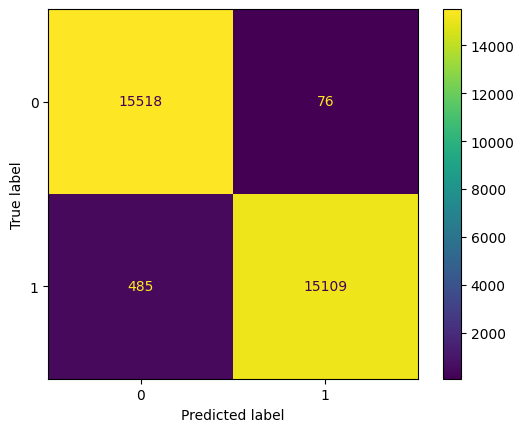

In [12]:
voter_cm = confusion_matrix(y, y_pred_voter)
voter_cmd = ConfusionMatrixDisplay(voter_cm)
voter_cmd.plot()

In [11]:
source = 'mlflow-artifacts:/345dcf209f6c4e558ae241b57e1bd5d5/9d2269666ff049bda7fa6894e18b869a/artifacts/candidate_Stacked_Classifier'
stacked_clf = mlflow.sklearn.load_model(source)
y_pred_stacked = stacked_clf.predict(x)
report_stacked = eval_metrics(y, y_pred_stacked)
report_stacked

{'Balanced_Accuracy_Score': 0.9018212132871617,
 'F1_Score': 0.8911559789563486,
 'Accuracy_Score': 0.9018212132871617,
 'Cost': 1529530.0}

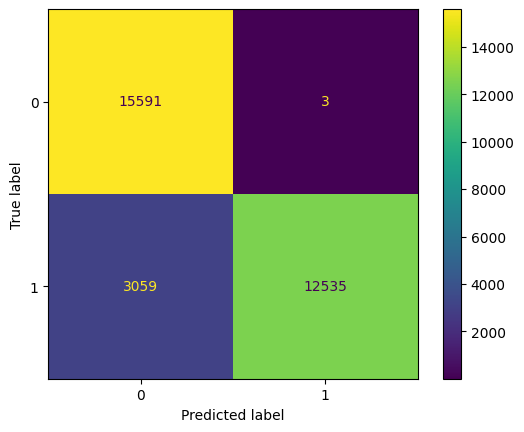

In [13]:
stacked_cm = confusion_matrix(y, y_pred_stacked)
stacked_cmd = ConfusionMatrixDisplay(stacked_cm)
stacked_cmd.plot()

In [14]:
source = 'mlflow-artifacts:/e4170a475e154897a8384bec97c3297e/5b0e9be884e641af824981ef888952cd/artifacts/challenger_LGBMClassifier'
lgbm = mlflow.sklearn.load_model(source)
y_pred_lgbm = lgbm.predict(x)
report_lgbm = eval_metrics(y, y_pred_lgbm)
report_lgbm

{'Balanced_Accuracy_Score': 0.9806015134025907,
 'F1_Score': 0.980268093017188,
 'Accuracy_Score': 0.9806015134025907,
 'Cost': 283390.0}

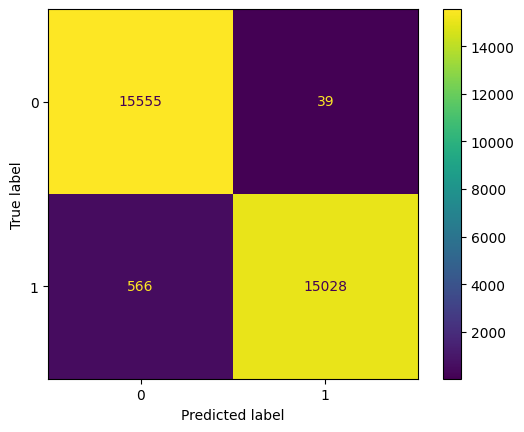

In [15]:
lgbm_cm = confusion_matrix(y, y_pred_lgbm)
lgbm_cmd = ConfusionMatrixDisplay(lgbm_cm)
lgbm_cmd.plot()

In [22]:
exp_id = list(range(564,580))
exp_id

[564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579]

In [39]:
parent_runs = mlflow.search_registered_models()
runs_df = mlflow.search_runs(experiment_ids = exp_id,
                                search_all_experiments = True,
                                filter_string = f"tags.run_type ilike 'parent'")
runs_list_ = [parent_runs[i].latest_versions[0].run_id for i in range(len(parent_runs))]
best_run = runs_df[runs_df['run_id'].isin(runs_list_)].sort_values(by = "metrics.Accuracy_Score", ascending=False).reset_index(drop=True)['run_id'][0]
best_artifact = runs_df[runs_df['run_id'].isin(runs_list_)].sort_values(by = "metrics.Accuracy_Score", ascending=False).reset_index(drop=True)['artifact_uri'][0]
artifact_path_name = client.list_artifacts(f'{best_run}')[0].path
best_exp_id = runs_df[runs_df['run_id'] == best_run]['experiment_id'].values[0]
model_name = json.loads(runs_df[runs_df['run_id'].isin(runs_list_)].sort_values(by = "metrics.Accuracy_Score", ascending=False).reset_index(drop=True)['tags.mlflow.log-model.history'][0])[0]['artifact_path']
# model_name = model_name.replace("Optuna for ", "")
model_name = re.sub(r'candidate_', '', model_name)



In [40]:
model_name

'Light_GBM'

In [34]:
import json
json.loads(runs_df[runs_df['run_id'].isin(runs_list_)].sort_values(by = "metrics.Accuracy_Score", ascending=False).reset_index(drop=True)['tags.mlflow.log-model.history'][0])[0]['artifact_path']

'candidate_Light_GBM'

In [35]:
json.loads(runs_df[runs_df['run_id'].isin(runs_list_)].sort_values(by = "metrics.Accuracy_Score", ascending=False).reset_index(drop=True)['tags.mlflow.log-model.history'][0])[0]['artifact_path']

'candidate_Light_GBM'

In [42]:
registered_model_name = 'Candidate_'
model_name = 'Light_GBM'
print(f"{registered_model_name}{model_name}")

Candidate_Light_GBM


In [44]:
client.set_registered_model_tag(name = 'Challenger Voting_Classifier',
                                key = 'model_type',
                                value = 'Challenger')

In [72]:
filter_string = None

In [93]:
filter_string = f"tags.model_type ilike 'Challenger'"

In [94]:
registered_models = {mlflow.search_registered_models(filter_string = filter_string)[i].latest_versions[0].name : mlflow.search_registered_models(filter_string = filter_string)[i].latest_versions[0].run_id for i in range(len(mlflow.search_registered_models(filter_string = filter_string)))}

In [143]:
sources = []
for i in range(3):
    sources.append(mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'Challenger'")[i].latest_versions[0].source)
sources

['mlflow-artifacts:/e4170a475e154897a8384bec97c3297e/5b0e9be884e641af824981ef888952cd/artifacts/challenger_LGBMClassifier',
 'mlflow-artifacts:/345dcf209f6c4e558ae241b57e1bd5d5/9d2269666ff049bda7fa6894e18b869a/artifacts/candidate_Stacked_Classifier',
 'mlflow-artifacts:/ab3547075e654292b08e9f8f13d7dbf4/96c114f6f6f1409da17f19672d77a0ab/artifacts/candidate_Voting_Classifier']

In [139]:
mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'Challenger'")[2].name#[i].latest_versions[0]

'Challenger Voting_Classifier'

In [140]:
data = pd.read_csv(r"F:\iNeuron\Projects\scania_failures_2\artifacts\data\transformed_test_df.csv")
x = data.drop(columns = 'class')
y = data['class']
report = {}
for i in range(len(sources)):
    model = mlflow.sklearn.load_model(sources[i])
    report[mlflow.search_registered_models(filter_string = f"tags.model_type ilike 'Challenger'")[i].name] = eval_metrics(y_true = y, 
                                                    y_pred = model.predict(x))

[2024-02-03 23:51:44,384: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/e4170a475e154897a8384bec97c3297e/5b0e9be884e641af824981ef888952cd/artifacts/challenger_LGBMClassifier/python_env.yaml]
[2024-02-03 23:51:44,413: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/e4170a475e154897a8384bec97c3297e/5b0e9be884e641af824981ef888952cd/artifacts/challenger_LGBMClassifier/conda.yaml]
[2024-02-03 23:51:44,419: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnecte

In [145]:
report_df = pd.DataFrame(report).T.sort_values(by = 'Accuracy_Score',ascending = False)

In [151]:
list(report_df.iloc[:1,:]['Accuracy_Score'].index)[0]

'Challenger Voting_Classifier'

In [156]:
list(report_df.iloc[:1,:]['Accuracy_Score'].values)[0]

0.9820123124278569

In [162]:
client.set_registered_model_alias(name = 'Challenger LGBMClassifier',
                                          alias = 'champion',
                                          version = '1')

In [124]:
models[0].__class__.__name__

'LGBMClassifier'

In [95]:
registered_models

{'Challenger LGBMClassifier': '5b0e9be884e641af824981ef888952cd',
 'Challenger Stacked_Classifier': '9d2269666ff049bda7fa6894e18b869a',
 'Challenger Voting_Classifier': '96c114f6f6f1409da17f19672d77a0ab'}

In [96]:
run_details = {}
for key,value in registered_models.items():
    run_details[client.get_run(value).data.tags['model']] = {}
    run_details[client.get_run(value).data.tags['model']]['accuracy'] = client.get_run(value).data.metrics['Accuracy_Score']
    run_details[client.get_run(value).data.tags['model']]['params'] = params_evaluator(client.get_run(value).data.params)

# Create a dataframe from the "run_details" dict and sort it by "accuracy" in DESC
# In this dataframe only the models whose accuracy is greater than 0.9 are chosen.
models_df = pd.DataFrame(run_details).T

sorted_models_df = models_df[models_df['accuracy'] > 0.9].sort_values(by = 'accuracy', ascending=False)

In [97]:
sorted_models_df

,accuracy,params
LGBMClassifier,0.980208,{}
Voting_Classifier,0.976093,"{'estimators': [('Random Forest', 'RandomFores..."
Stacked_Classifier,0.924029,"{'estimators': [('Random Forest', 'RandomFores..."


In [105]:
sorted_models_df.iloc[:1,]['accuracy'].values

array([0.980208120791675], dtype=object)

In [49]:
mlflow_models = {key:value(**(sorted_models_df.params[key])) for key,value in models.items() if  key in sorted_models_df.index}

    # Create the list[tuple] best_estimators to fit in the voting classifier
best_estimators_mlflow = list(zip(mlflow_models.keys(),mlflow_models.values()))

# If using stacking classifier, get the final estimator using:
final_estimator_mlflow = {key:value(**(sorted_models_df.iloc[:1,:].params[key])) for key,value in models.items() if key in sorted_models_df.iloc[:1,:].index}
# Access the final estimator model using:

final_estimator = final_estimator_mlflow[sorted_models_df.iloc[:1,:].index.values[0]]


In [50]:
mlflow_models

{'Random Forest': RandomForestClassifier(class_weight='balanced_subsample'),
 'Ada_Boost': AdaBoostClassifier(algorithm='SAMME', n_estimators=105),
 'Bagging_Classifier': BaggingClassifier(n_estimators=79),
 'ExtraTreesClassifier': ExtraTreesClassifier(class_weight='balanced', max_features='log2',
                      n_estimators=207),
 'XGB_Classifier': XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.19527551803044957, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints=(),
               n_estimators=413, n_jobs=0, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='approx', validate_parameters=1, verbosity=None),
 'Light_GBM': LGBMClassifier(class_weight='bal

In [51]:
best_estimators_mlflow

[('Random Forest', RandomForestClassifier(class_weight='balanced_subsample')),
 ('Ada_Boost', AdaBoostClassifier(algorithm='SAMME', n_estimators=105)),
 ('Bagging_Classifier', BaggingClassifier(n_estimators=79)),
 ('ExtraTreesClassifier',
  ExtraTreesClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=207)),
 ('XGB_Classifier',
  XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.19527551803044957, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=(),
                n_estimators=413, n_jobs=0, num_parallel_tree=1, random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                tree_method='approx', validate_parameters=1, verbosity=None)),
 ('Light_GBM',
  LGBMCla

In [52]:
final_estimator_mlflow

{'Light_GBM': LGBMClassifier(class_weight='balanced', learning_rate=0.4417276983128657,
                n_estimators=101, n_jobs=-1)}

In [53]:
final_estimator

LGBMClassifier(class_weight='balanced', learning_rate=0.4417276983128657,
               n_estimators=101, n_jobs=-1)

In [163]:
metrics_stacking_clf = 3
metrics_voting_clf = 5
metrics_final_estimator = 7

In [168]:
print(f"\nMetrics are: \n***************************\nStacking_CLF:\n{metrics_stacking_clf}\n**************************\nVoting_CLF:\n{metrics_voting_clf}\n**************************\nfinal_estimator:\n{metrics_final_estimator}\n**************************\n")


Metrics are: 
***************************
Stacking_CLF:
3
**************************
Voting_CLF:
5
**************************
final_estimator:
7
**************************

